# Energy conserving network in tf.keras

This is using https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/005_Predicting_convective_and_radiative_heating_profiles.ipynb



In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cbrain.imports import *
from cbrain.utils import *

## Preprocess 

In [9]:
!python ../../preprocessing.py -c ../../pp_config/002_32col_tom.yml

2019-04-02 14:02:04.405617: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
2019-04-02 14:02:04.559464: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1432] Found device 0 with properties: 
name: GeForce GTX 1080 major: 6 minor: 1 memoryClockRate(GHz): 1.7335
pciBusID: 0000:b3:00.0
totalMemory: 7.93GiB freeMemory: 5.91GiB
2019-04-02 14:02:04.559497: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1511] Adding visible gpu devices: 0
2019-04-02 14:02:05.066076: I tensorflow/core/common_runtime/gpu/gpu_device.cc:982] Device interconnect StreamExecutor with strength 1 edge matrix:
2019-04-02 14:02:05.066113: I tensorflow/core/common_runtime/gpu/gpu_device.cc:988]      0 
2019-04-02 14:02:05.066121: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1001] 0:   N 
2019-04-02 14:02:05.066456: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1115] Created TensorF

## Output normalization using Pressure levels

Using the dict normalizer

In [3]:
out_vars = ['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE', 
            'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT', 'PRECTEND', 'PRECST', 'PRECSTEN']

In [4]:
from cbrain.cam_constants import *

In [5]:
scale_dict = {
    'PHQ': L_V/G, 
    'PHCLDLIQ': L_V/G, 
    'PHCLDICE': L_V/G, 
    'TPHYSTND': C_P/G, 
    'QRL': C_P/G, 
    'QRS': C_P/G, 
    'DTVKE': C_P/G, 
    'FSNT': 1, 
    'FSNS': 1, 
    'FLNT': 1, 
    'FLNS': 1, 
    'PRECT': RHO_L*L_V, 
    'PRECTEND': 1e-3*RHO_L*L_V, 
    'PRECST': RHO_L*L_V, 
    'PRECSTEN': 1e-3*RHO_L*L_V
}

In [6]:
with open(os.path.join(os.path.dirname('../../cbrain/'), 'hyai_hybi.pkl'), 'rb') as f:
    hyai, hybi = pickle.load(f)

In [7]:
# Takes representative value for PS since purpose is normalization
PS = 1e5; P0 = 1e5;
P = P0*hyai+PS*hybi; # Total pressure [Pa]
dP = P[1:]-P[:-1]; # Differential pressure [Pa]  

In [8]:
dP.shape

(30,)

In [9]:
for v in ['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS']:
    scale_dict[v] *= dP
scale_dict['DTVKE'] *= (dP/DT)

In [39]:
save_pickle('../../nn_config/scale_dicts/001_toms_scaling.pkl', scale_dict)

In [42]:
scale_dict = load_pickle('../../nn_config/scale_dicts/001_toms_scaling.pkl')

In [10]:
scale_dict['PHQ']

array([7.0811688e+07, 1.3074195e+08, 2.1416968e+08, 3.0895507e+08,
       3.8762448e+08, 4.4520454e+08, 4.4321338e+08, 3.6317286e+08,
       4.2725360e+08, 5.0264170e+08, 5.9133267e+08, 6.9567149e+08,
       8.1842150e+08, 9.6283104e+08, 1.1327212e+09, 1.3325868e+09,
       1.5677202e+09, 1.8443410e+09, 2.1697718e+09, 2.1706406e+09,
       1.9922205e+09, 1.6811768e+09, 1.2494753e+09, 7.2336192e+08,
       6.7863757e+08, 6.2842387e+08, 5.7302957e+08, 5.1279936e+08,
       4.4820157e+08, 3.7970438e+08], dtype=float32)

In [17]:
from cbrain.data_generator import DataGenerator
from cbrain.normalization import DictNormalizer

In [18]:
in_vars = ['QBP', 'QCBP', 'QIBP', 'TBP', 'VBP', 
           'Qdt_adiabatic', 'QCdt_adiabatic', 'QIdt_adiabatic', 'Tdt_adiabatic', 'Vdt_adiabatic',
           'PS', 'SOLIN', 'SHFLX', 'LHFLX']

In [19]:
train_gen.data_ds.close()

NameError: name 'train_gen' is not defined

In [20]:
train_gen = DataGenerator(
    data_fn = '/local/S.Rasp/preprocessed_data/000_train_shuffle.nc',
    input_vars = in_vars,
    output_vars = out_vars,
    norm_fn = '/local/S.Rasp/preprocessed_data/000_norm.nc',
    input_transform = ('mean', 'std_by_var'),
    output_transform = scale_dict,
    batch_size=1024,
    shuffle=True
)

In [61]:
X, Y = train_gen[0]

In [62]:
train_gen.output_idxs

array([154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179,
       180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192,
       193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205,
       206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218,
       219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231,
       232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244,
       245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257,
       258, 259, 260, 261, 262, 263, 264, 265, 266, 267, 268, 269, 270,
       271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283,
       284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296,
       297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309,
       310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322,
       323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 33

In [63]:
X[0,0]

4.543729e-05

In [64]:
X.shape, Y.shape

((1024, 304), (1024, 218))

(1e-06, 1000.0)

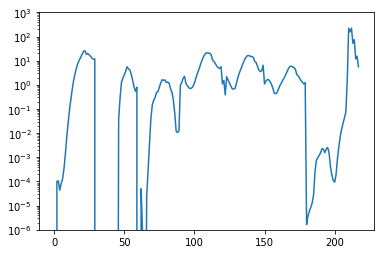

In [65]:
plt.plot(np.mean(np.abs(Y), 0))
plt.yscale('log')
plt.ylim(1e-6, 1e3)

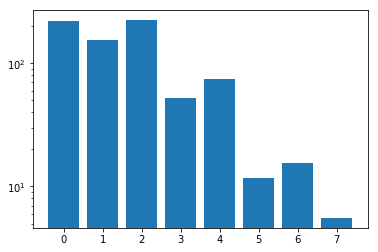

In [66]:
plt.bar(range(8), np.mean(np.abs(Y), 0)[-8:])
plt.yscale('log')

## Build the model

### Radiation conservation layer

In [67]:
#tf.enable_eager_execution()

In [68]:
from cbrain.utils import return_var_idxs

In [69]:
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K

In [70]:
in_vars

['QBP',
 'QCBP',
 'QIBP',
 'TBP',
 'VBP',
 'Qdt_adiabatic',
 'QCdt_adiabatic',
 'QIdt_adiabatic',
 'Tdt_adiabatic',
 'Vdt_adiabatic',
 'PS',
 'SOLIN',
 'SHFLX',
 'LHFLX']

In [71]:
print(out_vars)

['PHQ', 'PHCLDLIQ', 'PHCLDICE', 'TPHYSTND', 'QRL', 'QRS', 'DTVKE', 'FSNT', 'FSNS', 'FLNT', 'FLNS', 'PRECT', 'PRECTEND', 'PRECST', 'PRECSTEN']


In [72]:
inp_vars_full = train_gen.norm_ds.var_names[train_gen.input_idxs]

In [24]:
out_vars_full = train_gen.norm_ds.var_names[train_gen.output_idxs]

In [25]:
def return_var_slice(var_names, var):
    var_idxs = np.atleast_1d(np.squeeze(np.where(var_names == var)))
    return slice(int(var_idxs[0]), int(var_idxs[-1])+1)

In [73]:
def compute_dP_tilde(PS, hyai, hybi, PS_div, PS_sub, norm_q):
    """
    Computes dP_tilde in Tom's notation.
    PS is the normalized pressure as it is used in the input.
    PS_mult and PS_add are the corresponding values to unnormalize PS.
    WARNING: Really not sure about norm_q
    """
    PS = PS * PS_div + PS_sub
    P = P0 * hyai + PS[:, None] * hybi
    dP = P[:, 1:] - P[:, :-1]
    dP_norm = norm_q * G / L_V   # Why L_V?
    dP_tilde = dP / dP_norm
    return dP_tilde

In [84]:
class SurRadLayer(Layer):
    def __init__(self, inp_sub, inp_div, norm_q, **kwargs):
        """
        Call using ([input, output])
        Assumes
        prior: [PHQ_nores, PHCLDLIQ, PHCLDICE, TPHYSTND_nores, 
        QRL, QRS, DTVKE, FSNT, FLNT, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [PHQ_nores, PHCLDLIQ, PHCLDICE, TPHYSTND_nores, 
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        """
        self.inp_sub, self.inp_div, self.norm_q, self.hyai, self.hybi = \
            np.array(inp_sub), np.array(inp_div), np.array(norm_q), np.array(hyai), np.array(hybi)
        # Define variable indices here
        # Input
        self.PS_idx = 300
        # Output
        self.QRL_idx = slice(118, 148)  # Odd numbers because residuals
        self.QRS_idx = slice(148, 178)  # for Q and T are still missing
        self.FSNT_idx = 208
        self.FLNT_idx = 209
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)
        
    def get_config(self):
        config = {'inp_sub': list(self.inp_sub), 'inp_div': list(self.inp_div),
                  'norm_q': list(self.norm_q), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi)}
        base_config = super(SurRadLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
        
    def call(self, arrs):
        inp, prior = arrs
        
        # 1. Compute dP_tilde
        dP_tilde = compute_dP_tilde(
            inp[:, self.PS_idx], self.hyai, self.hybi, 
            self.inp_div[self.PS_idx], self.inp_sub[self.PS_idx],
            self.norm_q
        )
        
        # 2. Compute radiative integrals
        SWINT = K.sum(dP_tilde * prior[:, self.QRS_idx], 1)
        LWINT = K.sum(dP_tilde * prior[:, self.QRL_idx], 1)
        
        # 3. Infer surface fluxes from residual
        FSNS = prior[:, self.FSNT_idx] - SWINT
        FLNS = prior[:, self.FLNT_idx] + LWINT
        
        # 4. Concatenate output vector
        post = tf.concat([
            prior[:, :self.FLNT_idx], FSNS[:, None], 
            prior[:, self.FLNT_idx][:, None], FLNS[:, None],
            prior[:, (self.FLNT_idx+1):]
        ], axis=1)
        return post
    
    def compute_output_shape(self, input_shape):
        """Input shape + 2"""
        return (input_shape[0][0], input_shape[0][1] + 2)

In [94]:
inp_layer = Input(shape=(304,))
x = Dense(214, activation='elu')(inp_layer)
out_layer = SurRadLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30], hyai=hyai, hybi=hybi
)([inp_layer, x])
model = keras.models.Model(inp_layer, out_layer)

In [95]:
model.save('/home/s/S.Rasp/tmp/test_model.h5')

In [96]:
model = keras.models.load_model('/home/s/S.Rasp/tmp/test_model.h5',
                                custom_objects={'SurRadLayer': SurRadLayer})

#### Test 

In [29]:
# Create a fake output vector with the correct values
Y.shape

(1024, 218)

In [30]:
Y_fake = tf.concat(
    [Y[:, 0:29], Y[:, 30:119], Y[:, 120:211], Y[:, 212:213], Y[:, 214:]], 1
)

In [31]:
ll = model.layers[-1]

In [32]:
out_fake = ll([X, Y_fake])

In [33]:
out_fake.shape

TensorShape([Dimension(1024), Dimension(216)])

In [34]:
FSNS_fake = out_fake[:, 211].numpy()

AttributeError: 'Tensor' object has no attribute 'numpy'

In [ ]:
FSNS_true = Y[:, 213]

In [ ]:
plt.scatter(FSNS_fake, FSNS_true)

### Mass conservation layer

In [35]:
return_var_slice(inp_vars_full, 'LHFLX')

slice(303, 304, None)

In [85]:
class MassConsLayer(Layer):
    def __init__(self, inp_div, inp_sub, norm_q, **kwargs):
        """
        Call using ([input, output])
        Assumes
        prior: [PHQ_nores, PHCLDLIQ, PHCLDICE, TPHYSTND_nores, 
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND_nores, 
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        """
        self.inp_sub, self.inp_div, self.norm_q, self.hyai, self.hybi = \
            np.array(inp_sub), np.array(inp_div), np.array(norm_q), np.array(hyai), np.array(hybi)
        # Define variable indices here
        # Input
        self.PS_idx = 300
        self.LHFLX_idx = 303
        # Output
        self.PHQ_idx = slice(0, 29)   # Residual still missing
        self.PHCLDLIQ_idx = slice(29, 59)
        self.PHCLDICE_idx = slice(59, 89)
        self.PRECT_idx = 212
        self.PRECTEND_idx = 213
        
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)
        
    def get_config(self):
        config = {'inp_sub': list(self.inp_sub), 'inp_div': list(self.inp_div),
                  'norm_q': list(self.norm_q), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi)}
        base_config = super(SurRadLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
        
    def call(self, arrs):
        inp, prior = arrs

        # 1. Compute dP_tilde
        dP_tilde = compute_dP_tilde(
            inp[:, self.PS_idx], self.hyai, self.hybi, 
            self.inp_div[self.PS_idx], self.inp_sub[self.PS_idx],
            self.norm_q
        )
        
        # 2. Compute vertical cloud water integral
        CLDINT = K.sum(dP_tilde * 
            (prior[:, self.PHCLDLIQ_idx] + prior[:, self.PHCLDICE_idx]), 
        axis=1)
        
        # 3. Compute water vapor integral
        VAPINT = K.sum(dP_tilde[:, :29] * prior[:, self.PHQ_idx], 1)
        
        # 4. Compute forcing (see Tom's note for details, I am just copying)
        LHFLX = (inp[:, self.LHFLX_idx] * self.inp_div[self.LHFLX_idx] + 
                 self.inp_sub[self.LHFLX_idx])
        PREC = prior[:, self.PRECT_idx] + prior[:, self.PRECTEND_idx]
        
        # 5. Compute water vapor tendency at level 30 as residual
        PHQ30 = (LHFLX - PREC - CLDINT - VAPINT) / dP_tilde[:, 29]
        
        # 6. Concatenate output vector
        post = tf.concat([
            prior[:, self.PHQ_idx], PHQ30[:, None], 
            prior[:, 29:]
        ], axis=1)
        return post
    
    def compute_output_shape(self, input_shape):
        """Input shape + 1"""
        return (input_shape[0][0], input_shape[0][1] + 1)

#### Test

In [39]:
inp_layer = Input(shape=(154,))
x = Dense(214, activation='elu')(inp_layer)
x = SurRadLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
out_layer = MassConsLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
model = keras.models.Model(inp_layer, out_layer)

In [40]:
ll = model.layers[-1]

In [41]:
out_fake2 = ll([X, out_fake])

In [42]:
out_fake2.shape

TensorShape([Dimension(1024), Dimension(217)])

In [43]:
PHQ30_fake = out_fake2[:, 29].numpy()

In [44]:
PHQ30_true = Y[:, 29]

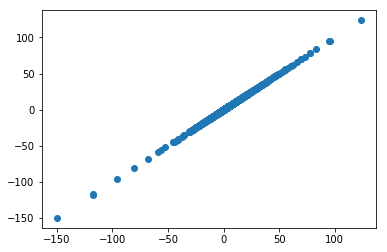

In [45]:
plt.scatter(PHQ30_fake, PHQ30_true)

### Enthalpy conservation

In [76]:
class EntConsLayer(Layer):
    def __init__(self, inp_div, inp_sub, norm_q, **kwargs):
        """
        Call using ([input, output])
        Assumes
        prior: [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND_nores, 
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND, 
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        """
        self.inp_sub, self.inp_div, self.norm_q, self.hyai, self.hybi = \
            np.array(inp_sub), np.array(inp_div), np.array(norm_q), np.array(hyai), np.array(hybi)
        # Define variable indices here
        # Input
        self.PS_idx = 300
        self.SHFLX_idx = 302
        self.LHFLX_idx = 303
        
        # Output
        self.PHQ_idx = slice(0, 30)
        self.PHCLDLIQ_idx = slice(30, 60)
        self.TPHYSTND_idx = slice(90, 119)  # Residual still missing
        self.DTVKE_idx = slice(179, 209)
        self.FSNT_idx = 209 
        self.FSNS_idx = 210
        self.FLNT_idx = 211
        self.FLNS_idx = 212
        self.PRECT_idx = 213
        self.PRECTEND_idx = 214
        self.PRECST_idx = 215
        self.PRECSTEND_idx = 216
        
        super().__init__(**kwargs)
        
    def build(self, input_shape):
        super().build(input_shape)
        
    def get_config(self):
        config = {'inp_sub': list(self.inp_sub), 'inp_div': list(self.inp_div),
                  'norm_q': list(self.norm_q), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi)}
        base_config = super(SurRadLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))
        
    def call(self, arrs):
        inp, prior = arrs

        # 1. Compute dP_tilde
        dP_tilde = compute_dP_tilde(
            inp[:, self.PS_idx], hyai, hybi, 
            self.inp_div[self.PS_idx], self.inp_sub[self.PS_idx],
            self.norm_q
        )
        
        # 2. Compute net energy input from phase change and precipitation
        PHAS = L_I / L_V * (
            (prior[:, self.PRECST_idx] + prior[:, self.PRECSTEND_idx]) - 
            (prior[:, self.PRECT_idx] + prior[:, self.PRECTEND_idx])
        )
        
        # 3. Compute net energy input from radiation, SHFLX and TKE
        RAD = (prior[:, self.FSNT_idx] - prior[:, self.FSNS_idx] - 
               prior[:, self.FLNT_idx] + prior[:, self.FLNS_idx])
        SHFLX = (inp[:, self.SHFLX_idx] * self.inp_div[self.SHFLX_idx] + 
                 self.inp_sub[self.SHFLX_idx])
        KEDINT = K.sum(dP_tilde * prior[:, self.DTVKE_idx], 1)
        
        # 4. Compute tendency of vapor due to phase change
        LHFLX = (inp[:, self.LHFLX_idx] * self.inp_div[self.LHFLX_idx] + 
                 self.inp_sub[self.LHFLX_idx])
        VAPINT = K.sum(dP_tilde * prior[:, self.PHQ_idx], 1)
        SPDQINT = (VAPINT - LHFLX) * L_S / L_V
        
        # 5. Same for cloud liquid water tendency
        SPDQCINT = K.sum(dP_tilde * prior[:, self.PHCLDLIQ_idx], 1) * L_I / L_V
        
        # 6. And the same for T but remember residual is still missing
        DTINT = K.sum(dP_tilde[:, :29] * prior[:, self.TPHYSTND_idx], 1)
        
        # 7. Compute DT30 as residual
        DT30 = (
            PHAS + RAD + SHFLX + KEDINT - SPDQINT - SPDQCINT - DTINT
        ) / dP_tilde[:, 29]
        
        # 8. Concatenate output vector
        post = tf.concat([
            prior[:, :119], DT30[:, None], prior[:, 119:]
        ], axis=1)
        return post
    
    def compute_output_shape(self, input_shape):
        """Input shape + 1"""
        return (input_shape[0][0], input_shape[0][1] + 1)

#### Test

In [47]:
inp_layer = Input(shape=(154,))
x = Dense(214, activation='elu')(inp_layer)
x = SurRadLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
x = MassConsLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
out_layer = EntConsLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
model = keras.models.Model(inp_layer, out_layer)

In [48]:
ll = model.layers[-1]

In [49]:
out_fake3 = ll([X, out_fake2])

In [50]:
out_fake3.shape

TensorShape([Dimension(1024), Dimension(218)])

In [51]:
DT30_fake = out_fake3[:, 119].numpy()

In [52]:
DT30_true = Y[:, 119]

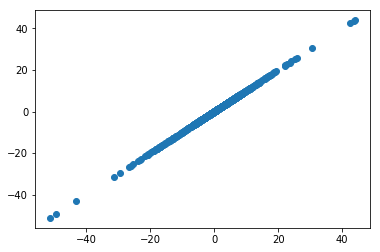

In [53]:
plt.scatter(DT30_fake, DT30_true)

## Full network test

In [54]:
inp_layer = Input(shape=(304,))
x = Dense(214, activation='elu')(inp_layer)
x = SurRadLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
x = MassConsLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
out_layer = EntConsLayer(
    inp_div=train_gen.input_transform.maxrs,
    inp_sub=train_gen.input_transform.mean,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
model = keras.models.Model(inp_layer, out_layer)

In [55]:
model.compile(keras.optimizers.Adam(lr=0.01), 'mse')

ValueError: optimizer must be an instance of tf.train.Optimizer, not a <class 'tensorflow.python.keras.optimizers.Adam'>

In [ ]:
model.fit_generator(train_gen, epochs=1)

In [ ]:
preds = model.predict_generator(train_gen)

In [ ]:
plt.plot(preds[0])
plt.plot(Y[0])

## Weakly constrained loss

### Mass residual

In [77]:
def mass_res(inp, pred, inp_div, inp_sub, norm_q):
    
    # Input
    PS_idx = 300
    LHFLX_idx = 303

    # Output
    PHQ_idx = slice(0, 30)
    PHCLDLIQ_idx = slice(30, 60)
    PHCLDICE_idx = slice(60, 90)
    PRECT_idx = 214
    PRECTEND_idx = 215
    
    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(
            inp[:, PS_idx], hyai, hybi, 
            inp_div[PS_idx], inp_sub[PS_idx],
            norm_q
    )
    
    # 2. Compute water integral
    WATINT = K.sum(dP_tilde * 
            (pred[:, PHQ_idx] + pred[:, PHCLDLIQ_idx] + pred[:, PHCLDICE_idx]), 
        axis=1)
    
    # 3. Compute latent heat flux and precipitation forcings
    LHFLX = inp[:, LHFLX_idx] * inp_div[LHFLX_idx] + inp_sub[LHFLX_idx]
    PREC = pred[:, PRECT_idx] + pred[:, PRECTEND_idx]
    
    # 4. Compute water mass residual 
    WATRES = LHFLX - PREC - WATINT
    
    return K.square(WATRES)
    

In [39]:
mass_res(X, Y, inp_div=train_gen.input_transform.maxrs, inp_sub=train_gen.input_transform.mean,
         norm_q=scale_dict['PHQ'])

<tf.Tensor 'Square:0' shape=(1024,) dtype=float64>

### Enthalpy residual

In [78]:
def ent_res(inp, pred, inp_div, inp_sub, norm_q):
    
    # Input
    PS_idx = 300
    SHFLX_idx = 302
    LHFLX_idx = 303

    # Output
    PHQ_idx = slice(0, 30)
    PHCLDLIQ_idx = slice(30, 60)
    PHCLDICE_idx = slice(60, 90)
    TPHYSTND_idx = slice(90, 120)
    DTVKE_idx = slice(180, 210)
    FSNT_idx = 210 
    FSNS_idx = 211
    FLNT_idx = 212
    FLNS_idx = 213
    PRECT_idx = 214
    PRECTEND_idx = 215
    PRECST_idx = 216
    PRECSTEND_idx = 217
    
    # 1. Compute dP_tilde
    dP_tilde = compute_dP_tilde(
        inp[:, PS_idx], hyai, hybi, 
        inp_div[PS_idx], inp_sub[PS_idx],
        norm_q
    )

    # 2. Compute net energy input from phase change and precipitation
    PHAS = L_I / L_V * (
        (pred[:, PRECST_idx] + pred[:, PRECSTEND_idx]) - 
        (pred[:, PRECT_idx] + pred[:, PRECTEND_idx])
    )

    # 3. Compute net energy input from radiation, SHFLX and TKE
    RAD = (pred[:, FSNT_idx] - pred[:, FSNS_idx] - 
           pred[:, FLNT_idx] + pred[:, FLNS_idx])
    SHFLX = (inp[:, SHFLX_idx] * inp_div[SHFLX_idx] + 
             inp_sub[SHFLX_idx])
    KEDINT = K.sum(dP_tilde * pred[:, DTVKE_idx], 1)

    # 4. Compute tendency of vapor due to phase change
    LHFLX = (inp[:, LHFLX_idx] * inp_div[LHFLX_idx] + 
             inp_sub[LHFLX_idx])
    VAPINT = K.sum(dP_tilde * pred[:, PHQ_idx], 1)
    SPDQINT = (VAPINT - LHFLX) * L_S / L_V

    # 5. Same for cloud liquid water tendency
    SPDQCINT = K.sum(dP_tilde * pred[:, PHCLDLIQ_idx], 1) * L_I / L_V

    # 6. And the same for T but remember residual is still missing
    DTINT = K.sum(dP_tilde * pred[:, TPHYSTND_idx], 1)

    # 7. Compute enthalpy residual
    ENTRES = SPDQINT + SPDQCINT + DTINT - RAD - SHFLX - PHAS - KEDINT

    return K.square(ENTRES)

In [79]:
ent_res(X, Y, inp_div=train_gen.input_transform.maxrs, inp_sub=train_gen.input_transform.mean,
         norm_q=scale_dict['PHQ'])

AttributeError: 'InputNormalizer' object has no attribute 'maxrs'

In [80]:
from keras.losses import mse
class WeakLoss():
    def __init__(self, inp_tensor, inp_div, inp_sub, norm_q, alpha_mass=0.25, alpha_ent=0.25,
                 name='weak_loss'):
        self.inp_tensor, self.inp_div, self.inp_sub, self.norm_q, self.alpha_mass, self.alpha_ent = \
            inp_tensor, inp_div, inp_sub, norm_q, alpha_mass, alpha_ent
        self.alpha_mse = 1 - (alpha_mass + alpha_ent)
        self.__name__ = name
    
    def __call__(self, y_true, y_pred):
        loss  = self.alpha_mse  * mse(y_true, y_pred)
        loss += self.alpha_mass * mass_res(self.inp_tensor, y_pred, self.inp_div, self.inp_sub, self.norm_q)
        loss += self.alpha_ent  * ent_res( self.inp_tensor, y_pred, self.inp_div, self.inp_sub, self.norm_q)
        return loss

Using TensorFlow backend.


In [94]:
hyai = hyai.astype(np.float32)
hybi = hybi.astype(np.float32)

In [81]:
weak_loss = WeakLoss(X, inp_div=train_gen.input_transform.div, inp_sub=train_gen.input_transform.sub,
                     norm_q=scale_dict['PHQ'].astype(np.float32))

In [96]:
weak_loss(Y, Y)

<tf.Tensor: id=612, shape=(1024,), dtype=float32, numpy=
array([1.9942187e-10, 1.3690604e-11, 3.8965027e-09, ..., 2.8830982e-10,
       3.3253400e-09, 1.3909249e-09], dtype=float32)>

In [83]:
scale_dict['PHQ'].astype(np.float32)

array([7.0811688e+07, 1.3074195e+08, 2.1416968e+08, 3.0895507e+08,
       3.8762454e+08, 4.4520458e+08, 4.4321341e+08, 3.6317274e+08,
       4.2725363e+08, 5.0264179e+08, 5.9133267e+08, 6.9567130e+08,
       8.1842189e+08, 9.6283091e+08, 1.1327208e+09, 1.3325876e+09,
       1.5677192e+09, 1.8443416e+09, 2.1697718e+09, 2.1706404e+09,
       1.9922214e+09, 1.6811766e+09, 1.2494747e+09, 7.2336026e+08,
       6.7864000e+08, 6.2842355e+08, 5.7302906e+08, 5.1279840e+08,
       4.4820285e+08, 3.7970432e+08], dtype=float32)

### Test with compiled model

In [86]:
inp_layer = Input(shape=(304,))
x = Dense(214, activation='elu')(inp_layer)
x = SurRadLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
x = MassConsLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
out_layer = EntConsLayer(
    inp_div=train_gen.input_transform.div,
    inp_sub=train_gen.input_transform.sub,
    norm_q=train_gen.output_transform.scale[:30]
)([inp_layer, x])
model = keras.models.Model(inp_layer, out_layer)

In [87]:
inp_layer

<tf.Tensor 'input_3:0' shape=(?, 304) dtype=float32>

In [88]:
model.input

<tf.Tensor 'input_3:0' shape=(?, 304) dtype=float32>

In [63]:
weak_loss = WeakLoss(inp_layer, inp_div=train_gen.input_transform.maxrs, inp_sub=train_gen.input_transform.mean,
                     norm_q=scale_dict['PHQ'].astype(np.float32))

In [64]:
mass_loss = WeakLoss(inp_layer, inp_div=train_gen.input_transform.maxrs, inp_sub=train_gen.input_transform.mean,
                     norm_q=scale_dict['PHQ'].astype(np.float32), alpha_mass=1, alpha_ent=0, name='mass_loss')
ent_loss = WeakLoss(inp_layer, inp_div=train_gen.input_transform.maxrs, inp_sub=train_gen.input_transform.mean,
                     norm_q=scale_dict['PHQ'].astype(np.float32), alpha_mass=0, alpha_ent=1, name='ent_loss')

In [65]:
model.compile(keras.optimizers.Adam(lr=0.01), loss=weak_loss, metrics=[mass_loss, ent_loss, mse])

In [56]:
model.fit_generator(train_gen, epochs=1)

Epoch 1/1
3448/3448 [==============================] - 64s 19ms/step - loss: 686.9191 - mass_loss: 4.2529e-11 - ent_loss: 9.1629e-11 - mean_squared_error: 1373.8382


In [57]:
inp_layer = Input(shape=(304,))
x = Dense(256, activation='elu')(inp_layer)
out_layer = Dense(218)(x)
model = keras.models.Model(inp_layer, out_layer)

In [58]:
weak_loss = WeakLoss(inp_layer, inp_div=train_gen.input_transform.maxrs, inp_sub=train_gen.input_transform.mean,
                     norm_q=scale_dict['PHQ'].astype(np.float32))

In [59]:
mass_loss = WeakLoss(inp_layer, inp_div=train_gen.input_transform.maxrs, inp_sub=train_gen.input_transform.mean,
                     norm_q=scale_dict['PHQ'].astype(np.float32), alpha_mass=1, alpha_ent=0, name='mass_loss')
ent_loss = WeakLoss(inp_layer, inp_div=train_gen.input_transform.maxrs, inp_sub=train_gen.input_transform.mean,
                     norm_q=scale_dict['PHQ'].astype(np.float32), alpha_mass=0, alpha_ent=1, name='ent_loss')

In [60]:
model.compile(keras.optimizers.Adam(lr=0.01), loss=weak_loss, metrics=[mass_loss, ent_loss, mse])

In [61]:
model.fit_generator(train_gen, epochs=1)

Epoch 1/1
3448/3448 [==============================] - 49s 14ms/step - loss: 255.9675 - mass_loss: 55.7669 - ent_loss: 78.9435 - mean_squared_error: 444.5797


In [66]:
model.save('/home/s/S.Rasp/tmp/test_model.h5')

In [67]:
model = keras.models.load_model('/home/s/S.Rasp/tmp/test_model.h5')

ValueError: Unknown layer: SurRadLayer

# old stuff

In [60]:
def massent_check(x,y,fsub,fdiv,normq,hyai=hyai,hybi=hybi,outtype="graph"):
    import numpy as np
    # 0) Constants
    G = 9.80616; # Reference gravity constant [m.s-2]
    L_F = 3.337e5; # Latent heat of fusion of water [W.kg-1]
    L_V = 2.501e6; # Latent heat of vaporization of water [W.kg-1]
    L_S = L_F+L_V; # Latent heat of sublimation of water [W.kg-1]
    P0 = 1e5; # Reference surface pressure [Pa]   

    # WATER&ENTHALPY) Get non-dimensional pressure differences (p_tilde above)
    # In the input vector, PS is the 151st element after 
    # the first elements = [QBP, ..., VBP with shape 30*5=150]
    PS = np.add( np.multiply( x[:,300], fdiv[300]), fsub[300])
    # Reference for calculation of d_pressure is cbrain/models.py (e.g. QLayer)
    P = np.add( np.multiply( P0, hyai), \
    np.multiply( PS[:,None], hybi))
    dP = np.subtract( P[:, 1:], P[:, :-1])
    # norm_output = dp_norm * L_V/G so dp_norm = norm_output * G/L_V
    dP_NORM = np.divide( \
    np.multiply(normq[:30], \
              G),\
    L_V)
    # dp_tilde = dp/dp_norm
    dP_TILD = np.divide( dP, dP_NORM)

    # WATER.1) Calculate water vertical integral from level 1 to level 30
    WATVEC = np.multiply( dP_TILD, y[:, :30] + y[:, 30:60] + y[:, 60:90])
    WATINT = np.sum( WATVEC, axis=1)

    # WATER.2) Calculate forcing on the right-hand side (Net Evaporation-Precipitation)
    # E-P is already normalized to units W.m-2 in the output vector
    # so all we need to do is input-unnormalize LHF that is taken from the input vector
    LHF = np.add( np.multiply( x[:,303], fdiv[303]), fsub[303])
    # Note that total precipitation = PRECT + 1e-3*PRECTEND in the CAM model
    # PRECTEND already multiplied by 1e-3 in output vector so no need to redo it
    PREC = np.add( y[:, 214], y[:, 215])

    # WATER.FINAL) Residual = E-P-DWATER/DT
    WATRES = LHF-PREC-WATINT
    
    # ENTHALPY.1) Calculate net energy input from phase change and precipitation
    # PHAS = Lf/Lv*((PRECST+PRECSTEN)-(PRECT+PRECTEND))
    PHAS = np.divide( np.multiply( np.subtract(\
                                          np.add( y[:,216], y[:,217]),\
                                          np.add( y[:,214], y[:,215])),\
                                  L_F),\
                     L_V)
    
    # ENTHALPY.2) Calculate net energy input from radiation, sensible heat flux and turbulent KE
    # 2.1) RAD = FSNT-FSNS-FLNT+FLNS
    RAD = np.add(\
            np.subtract( y[:,210], y[:,211]),\
            np.subtract( y[:,213], y[:,212]))
    # 2.2) Unnormalize sensible heat flux
    SHF = np.add( np.multiply( x[:,302], fdiv[302]), fsub[302])
    # 2.3) Net turbulent kinetic energy dissipative heating is the column-integrated 
    # turbulent kinetic energy energy dissipative heating
    KEDVEC = np.multiply( dP_TILD, y[:, 180:210])
    KEDINT = np.sum( KEDVEC, axis=1)
    
    # ENTHALPY.3) Calculate tendency of normalized column water vapor due to phase change
    # 3.1) Column water vapor is the column integral of specific humidity
    PHQVEC = np.multiply( dP_TILD, y[:, :30])
    PHQINT = np.sum( PHQVEC, axis=1)
    # 3.2) Multiply by L_S/L_V to normalize (explanation above)
    SPDQINT = np.divide( np.multiply( np.subtract(\
                                                 PHQINT, LHF),\
                                    L_S),\
                       L_V)
    
    # ENTHALPY.4) Same operation for liquid water tendency but multiplied by L_F/L_V
    SPDQCINT = np.divide( np.multiply(\
                                  np.sum(\
                                         np.multiply( dP_TILD, y[:, 30:60]),\
                                         axis=1),\
                                  L_F),\
                     L_V)
    
    # ENTHALPY.5) Same operation for temperature tendency
    DTINT = np.sum( np.multiply( dP_TILD[:, :30], y[:, 90:120]), axis=1)
    
    # ENTHALPY.FINAL) Residual = SPDQ+SPDQC+DTINT-RAD-SHF-PHAS
    ENTRES = SPDQINT+SPDQCINT+DTINT-RAD-SHF-PHAS-KEDINT
    
    if outtype=="graph":
    
        import matplotlib.pyplot as plt
        from matplotlib import rc
        plt.rc('text', usetex=True)
        plt.rc('font', family='serif')

        plt.figure(num=None, figsize=(12, 3), dpi=80, facecolor='w', edgecolor='k')

        plt.subplot(121)
        plt.hist(WATRES)
        plt.xlabel(r"$\mathrm{Water\ Residual\ \left[W.m^{-2}\right]}$", fontsize=16)
        plt.ylabel(r'Number of samples', fontsize=16)
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)

        plt.subplot(122)
        plt.hist(ENTRES)
        plt.xlabel(r"$\mathrm{Enthalpy\ Residual\ \left[W.m^{-2}\right]}$", fontsize=16)
        plt.ylabel(r'Number of samples', fontsize=16)
        plt.xticks(fontsize=14); plt.yticks(fontsize=14)
    
    elif outtype=="list":
    
        return WATRES,ENTRES

In [61]:
massent_check(X, Y, fsub=train_gen.input_transform.mean, fdiv=train_gen.input_transform.maxrs, 
              normq=scale_dict['PHQ'], outtype='list')

(array([ 3.37404841e-06,  4.27865968e-07, -2.62853132e-06, ...,
         1.96227573e-06,  2.29038963e-06, -1.77446091e-06]),
 array([-1.44291760e-05, -1.56159686e-05, -7.70019677e-06, ...,
        -1.42725843e-05, -1.12495670e-05, -3.77831034e-06]))